In [1]:
import sys
sys.path.append('../')

In [2]:
device='cuda'

In [3]:
import torch
import matplotlib.pyplot as plt
from data_utils import load_mnist_dataset, prepare_data
from vectorhash import build_scaffold
from hippocampal_sensory_layers import (
    ExactPseudoInverseHippocampalSensoryLayer,
    IterativeBidirectionalPseudoInverseHippocampalSensoryLayer,
    HippocampalSensoryLayer,
    HebbianHippocampalSensoryLayer,
    HSPseudoInverseSHHebbieanHippocampalSensoryLayer,
)
from tqdm import tqdm
from data_utils import load_mnist_dataset
from matplotlib.axes import Axes

/home/ezrahuang/miniconda3/envs/ml/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/ezrahuang/miniconda3/envs/ml/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [4]:
def test_layer(
    layer: HippocampalSensoryLayer, hbook: torch.Tensor, sbook: torch.Tensor
):
    err_l1_first_img_s_h_s = -torch.ones(len(sbook))
    avg_accumulated_err_l2 = -torch.ones(len(sbook))
    first_img = sbook[0]

    for i in tqdm(range(len(sbook))):
        h = hbook[i]
        s = sbook[i]
        layer.learn(h, s)

        err_l1_first_img_s_h_s[i] = torch.mean(
            torch.abs(
                layer.sensory_from_hippocampal(
                    layer.hippocampal_from_sensory(first_img)
                )[0]
                - first_img
            )
        )

        avg_accumulated_err_l2[i] = torch.mean(
            (
                layer.sensory_from_hippocampal(
                    layer.hippocampal_from_sensory(sbook[:i+1])
                )
                - sbook[:i+1]
            )
            ** 2
        )
        if (
            err_l1_first_img_s_h_s[i] > 10e5
            or avg_accumulated_err_l2[i] > 10e5
            or torch.any(torch.isnan(err_l1_first_img_s_h_s[i]))
            or torch.any(torch.isnan(avg_accumulated_err_l2[i]))
        ):
            break

    return err_l1_first_img_s_h_s, avg_accumulated_err_l2


def plot_avg_acc_l2_err_on_ax(ax: Axes, avg_accumulated_err_l2: torch.Tensor, label):
    x = torch.arange(0, len(avg_accumulated_err_l2[0]))
    mean = avg_accumulated_err_l2.mean(dim=0)
    std = avg_accumulated_err_l2.std(dim=0)
    ax.plot(x, mean, label=label)
    ax.fill_between(x, mean-std, mean+std, alpha=0.2)

    return ax


def plot_first_img_l1_err_on_ax(ax: Axes, err_l1_first_img_s_h_s: torch.Tensor, label):
    x = torch.arange(0, len(err_l1_first_img_s_h_s[0]))
    mean = err_l1_first_img_s_h_s.mean(dim=0)
    std = err_l1_first_img_s_h_s.std(dim=0)
    ax.plot(x, mean, label=label)
    ax.fill_between(x, mean-std, mean+std, alpha=0.2)

    return ax


def set_ax_titles(ax: Axes, title, xtitle, ytitle):
    ax.set_title(title)
    ax.set_xlabel(xtitle)
    ax.set_ylabel(ytitle)
    ax.legend()


def add_vertical_bar_on_ax(ax: Axes, x):
    ax.axvline(x=x, color="b", linestyle="--")

Analytic vs. Iterative pseudoinverse

In [54]:
dataset = load_mnist_dataset()
N_patts = 600
data, noisy_data = prepare_data(dataset, N_patts, noise_level='none', device=device)
runs=1

N_h = 400
shapes = [(3,3,3),(4,4,4),]
scaffold, mean_h = build_scaffold(shapes, N_h, device=device, sanity_check=True)

module shapes:  [(3, 3, 3), (4, 4, 4)]
N_g     :  91
N_patts :  1728
N_h     :  400


/home/ezrahuang/miniconda3/envs/ml/lib/python3.10/site-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


In [55]:
names = ["analytic", "iterative"]
err_l1_first_img_s_h_s = -torch.ones(2, runs, N_patts)
avg_accumulated_err_l2 = -torch.ones(2, runs, N_patts)

scaffold, mean_h = build_scaffold(shapes, N_h, device=device, sanity_check=True)
for i, name in enumerate(names):
    for run in range(runs):
        if name == "analytic":
            layer = ExactPseudoInverseHippocampalSensoryLayer(
                784, N_h, N_patts, scaffold.H[:N_patts], device=device
            )
        else:
            layer = IterativeBidirectionalPseudoInverseHippocampalSensoryLayer(
                784, N_h, 1, True, 0.1, 0.1, device=device
            )
        err_l1_first_img_s_h_s[i, run], avg_accumulated_err_l2[i, run] = test_layer(
            layer, scaffold.H, data[torch.randperm(len(data))]
        )

module shapes:  [(3, 3, 3), (4, 4, 4)]
N_g     :  91
N_patts :  1728
N_h     :  400


  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]/home/ezrahuang/Projects/rl-research/vectorhash/experiments/../hippocampal_sensory_layers.py:104: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3725.)
  1 + input.T @ self.inhibition_matrix_hs @ input
100%|██████████| 600/600 [00:01<00:00, 405.74it/s]


/tmp/ipykernel_7356/3700986534.py:45: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1831.)
  std = avg_accumulated_err_l2.std(dim=0)
/tmp/ipykernel_7356/3700986534.py:55: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1831.)
  std = err_l1_first_img_s_h_s.std(dim=0)


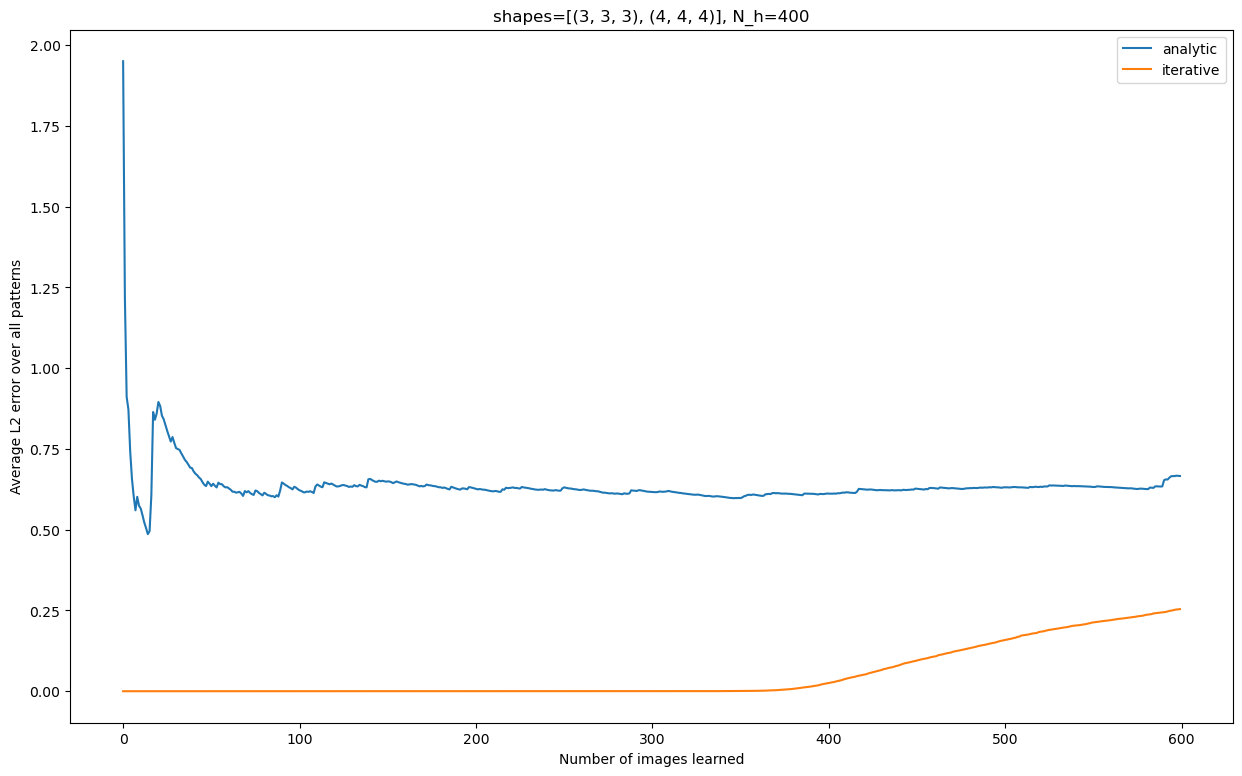

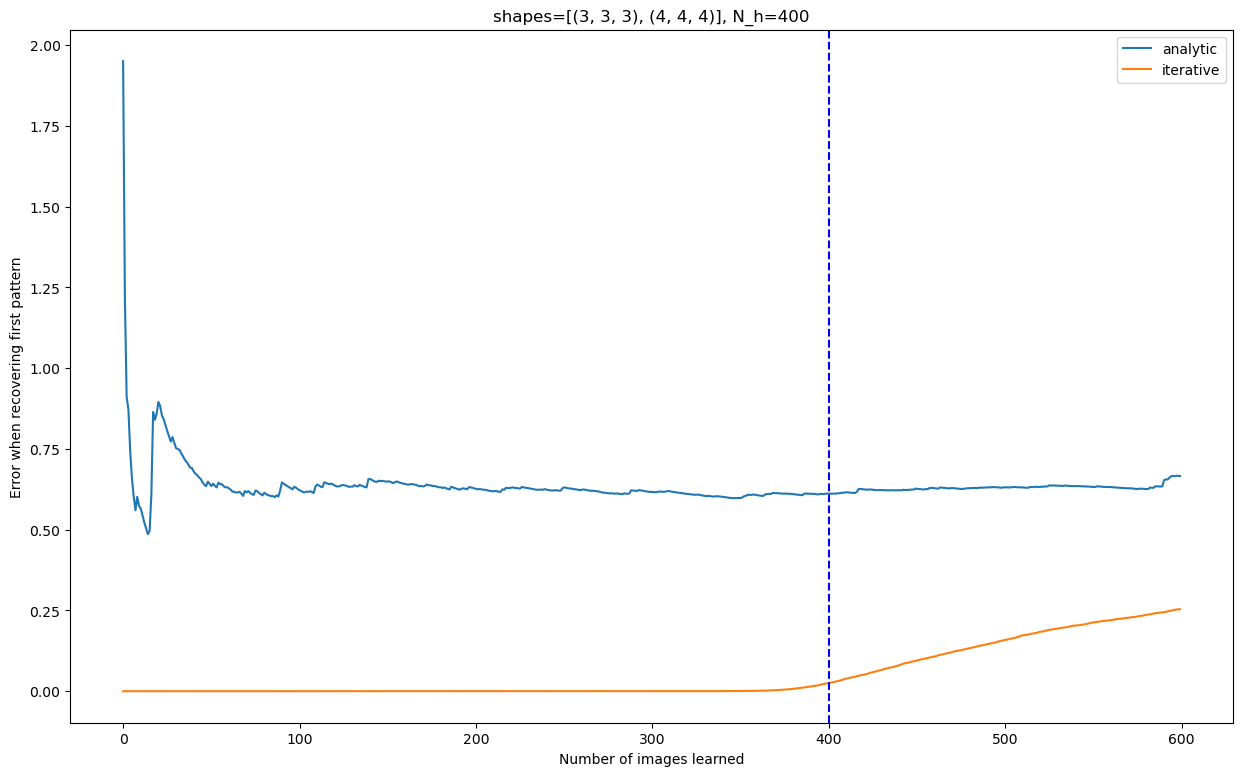

In [56]:
fig, ax = plt.subplots(figsize=(15, 9))

for i, name in enumerate(names):
    plot_avg_acc_l2_err_on_ax(ax, avg_accumulated_err_l2[i], label=name)
  
set_ax_titles(
    ax,
    f"shapes={shapes}, N_h={N_h}",
    "Number of images learned",
    "Average L2 error over all patterns",
)
fig.savefig("hipp_sens_result_analytic_vs_iterative_dataset_err")

fig, ax = plt.subplots(figsize=(15, 9))
for i, name in enumerate(names):
    plot_first_img_l1_err_on_ax(ax, avg_accumulated_err_l2[i], label=name)
    # label=f"iterative hidden_layer_factor={1}, stationary={True}, epsilon_W_sh={0.1}, epsilon_W_hs={0.1}",
    
add_vertical_bar_on_ax(ax, N_h)
set_ax_titles(
    ax,
    f"shapes={shapes}, N_h={N_h}",
    "Number of images learned",
    "Error when recovering first pattern",
)
fig.savefig("hipp_sens_result_analytic_vs_iterative_first_img_err")

Different Hebbian variations

In [5]:
dataset = load_mnist_dataset()
N_patts = 600
data, noisy_data = prepare_data(dataset, N_patts, noise_level="none", device=device)

N_h = 400
shapes = [
    (3, 3, 3),
    (4, 4, 4),
]
scaling_methods = ["norm", "n_h"]
means = [None, 0]
scaling_updates = [True, False]
runs = 5

err_l1_first_img_s_h_s = -torch.ones(
    len(scaling_methods), len(means), len(scaling_updates), runs, N_patts
)
avg_accumulated_err_l2 = -torch.ones(
    len(scaling_methods), len(means), len(scaling_updates), runs, N_patts
)

for i, scaling_method in enumerate(scaling_methods):
    for j, mean in enumerate(means):
        for k, scaling_update in enumerate(scaling_updates):
            if mean != None and scaling_method == "n_h":
                continue

            for run in range(runs):
                scaffold, mean_h = build_scaffold(shapes, N_h, device=device, sanity_check=True)
                layer = HebbianHippocampalSensoryLayer(
                    784, N_h, scaling_method, mean != None, mean_h, scaling_update, device
                )
                (
                    err_l1_first_img_s_h_s[i, j, k, run],
                    avg_accumulated_err_l2[i, j, k, run],
                ) = test_layer(layer, scaffold.H, data[torch.randperm(len(data))])

/home/ezrahuang/miniconda3/envs/ml/lib/python3.10/site-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


module shapes:  [(3, 3, 3), (4, 4, 4)]
N_g     :  91
N_patts :  1728
N_h     :  400
mean_h is defined but will not be used because use_h_fix is false


100%|██████████| 600/600 [00:01<00:00, 577.80it/s]


module shapes:  [(3, 3, 3), (4, 4, 4)]
N_g     :  91
N_patts :  1728
N_h     :  400
mean_h is defined but will not be used because use_h_fix is false


100%|██████████| 600/600 [00:00<00:00, 696.49it/s]


module shapes:  [(3, 3, 3), (4, 4, 4)]
N_g     :  91
N_patts :  1728
N_h     :  400
mean_h is defined but will not be used because use_h_fix is false


100%|██████████| 600/600 [00:00<00:00, 841.54it/s] 


module shapes:  [(3, 3, 3), (4, 4, 4)]
N_g     :  91
N_patts :  1728
N_h     :  400
mean_h is defined but will not be used because use_h_fix is false


100%|██████████| 600/600 [00:00<00:00, 708.27it/s]


module shapes:  [(3, 3, 3), (4, 4, 4)]
N_g     :  91
N_patts :  1728
N_h     :  400
mean_h is defined but will not be used because use_h_fix is false


100%|██████████| 600/600 [00:00<00:00, 736.81it/s]


module shapes:  [(3, 3, 3), (4, 4, 4)]
N_g     :  91
N_patts :  1728
N_h     :  400
mean_h is defined but will not be used because use_h_fix is false


100%|██████████| 600/600 [00:00<00:00, 897.21it/s] 


module shapes:  [(3, 3, 3), (4, 4, 4)]
N_g     :  91
N_patts :  1728
N_h     :  400
mean_h is defined but will not be used because use_h_fix is false


100%|██████████| 600/600 [00:00<00:00, 741.98it/s]


module shapes:  [(3, 3, 3), (4, 4, 4)]
N_g     :  91
N_patts :  1728
N_h     :  400
mean_h is defined but will not be used because use_h_fix is false


100%|██████████| 600/600 [00:00<00:00, 853.19it/s]


module shapes:  [(3, 3, 3), (4, 4, 4)]
N_g     :  91
N_patts :  1728
N_h     :  400
mean_h is defined but will not be used because use_h_fix is false


100%|██████████| 600/600 [00:00<00:00, 653.79it/s]


module shapes:  [(3, 3, 3), (4, 4, 4)]
N_g     :  91
N_patts :  1728
N_h     :  400
mean_h is defined but will not be used because use_h_fix is false


100%|██████████| 600/600 [00:00<00:00, 729.59it/s]


module shapes:  [(3, 3, 3), (4, 4, 4)]
N_g     :  91
N_patts :  1728
N_h     :  400


100%|██████████| 600/600 [00:01<00:00, 535.41it/s]


module shapes:  [(3, 3, 3), (4, 4, 4)]
N_g     :  91
N_patts :  1728
N_h     :  400


100%|██████████| 600/600 [00:01<00:00, 562.94it/s]


module shapes:  [(3, 3, 3), (4, 4, 4)]
N_g     :  91
N_patts :  1728
N_h     :  400


100%|██████████| 600/600 [00:01<00:00, 573.86it/s]


module shapes:  [(3, 3, 3), (4, 4, 4)]
N_g     :  91
N_patts :  1728
N_h     :  400


100%|██████████| 600/600 [00:00<00:00, 609.56it/s]


module shapes:  [(3, 3, 3), (4, 4, 4)]
N_g     :  91
N_patts :  1728
N_h     :  400


100%|██████████| 600/600 [00:01<00:00, 582.50it/s]


module shapes:  [(3, 3, 3), (4, 4, 4)]
N_g     :  91
N_patts :  1728
N_h     :  400


100%|██████████| 600/600 [00:00<00:00, 807.58it/s]


module shapes:  [(3, 3, 3), (4, 4, 4)]
N_g     :  91
N_patts :  1728
N_h     :  400


100%|██████████| 600/600 [00:01<00:00, 587.65it/s]


module shapes:  [(3, 3, 3), (4, 4, 4)]
N_g     :  91
N_patts :  1728
N_h     :  400


100%|██████████| 600/600 [00:00<00:00, 656.76it/s]


module shapes:  [(3, 3, 3), (4, 4, 4)]
N_g     :  91
N_patts :  1728
N_h     :  400


100%|██████████| 600/600 [00:01<00:00, 472.01it/s]


module shapes:  [(3, 3, 3), (4, 4, 4)]
N_g     :  91
N_patts :  1728
N_h     :  400


100%|██████████| 600/600 [00:00<00:00, 795.70it/s]


module shapes:  [(3, 3, 3), (4, 4, 4)]
N_g     :  91
N_patts :  1728
N_h     :  400
mean_h is defined but will not be used because use_h_fix is false


  2%|▏         | 10/600 [00:00<00:00, 786.92it/s]


module shapes:  [(3, 3, 3), (4, 4, 4)]
N_g     :  91
N_patts :  1728
N_h     :  400
mean_h is defined but will not be used because use_h_fix is false


  1%|          | 7/600 [00:00<00:02, 262.90it/s]


module shapes:  [(3, 3, 3), (4, 4, 4)]
N_g     :  91
N_patts :  1728
N_h     :  400
mean_h is defined but will not be used because use_h_fix is false


  2%|▏         | 9/600 [00:00<00:01, 556.38it/s]


module shapes:  [(3, 3, 3), (4, 4, 4)]
N_g     :  91
N_patts :  1728
N_h     :  400
mean_h is defined but will not be used because use_h_fix is false


  1%|▏         | 8/600 [00:00<00:01, 302.26it/s]


module shapes:  [(3, 3, 3), (4, 4, 4)]
N_g     :  91
N_patts :  1728
N_h     :  400
mean_h is defined but will not be used because use_h_fix is false


  1%|          | 7/600 [00:00<00:01, 452.47it/s]


module shapes:  [(3, 3, 3), (4, 4, 4)]
N_g     :  91
N_patts :  1728
N_h     :  400
mean_h is defined but will not be used because use_h_fix is false


100%|██████████| 600/600 [00:00<00:00, 838.93it/s]


module shapes:  [(3, 3, 3), (4, 4, 4)]
N_g     :  91
N_patts :  1728
N_h     :  400
mean_h is defined but will not be used because use_h_fix is false


100%|██████████| 600/600 [00:00<00:00, 890.40it/s] 


module shapes:  [(3, 3, 3), (4, 4, 4)]
N_g     :  91
N_patts :  1728
N_h     :  400
mean_h is defined but will not be used because use_h_fix is false


100%|██████████| 600/600 [00:00<00:00, 956.65it/s] 


module shapes:  [(3, 3, 3), (4, 4, 4)]
N_g     :  91
N_patts :  1728
N_h     :  400
mean_h is defined but will not be used because use_h_fix is false


100%|██████████| 600/600 [00:00<00:00, 855.71it/s]


module shapes:  [(3, 3, 3), (4, 4, 4)]
N_g     :  91
N_patts :  1728
N_h     :  400
mean_h is defined but will not be used because use_h_fix is false


100%|██████████| 600/600 [00:00<00:00, 804.76it/s]


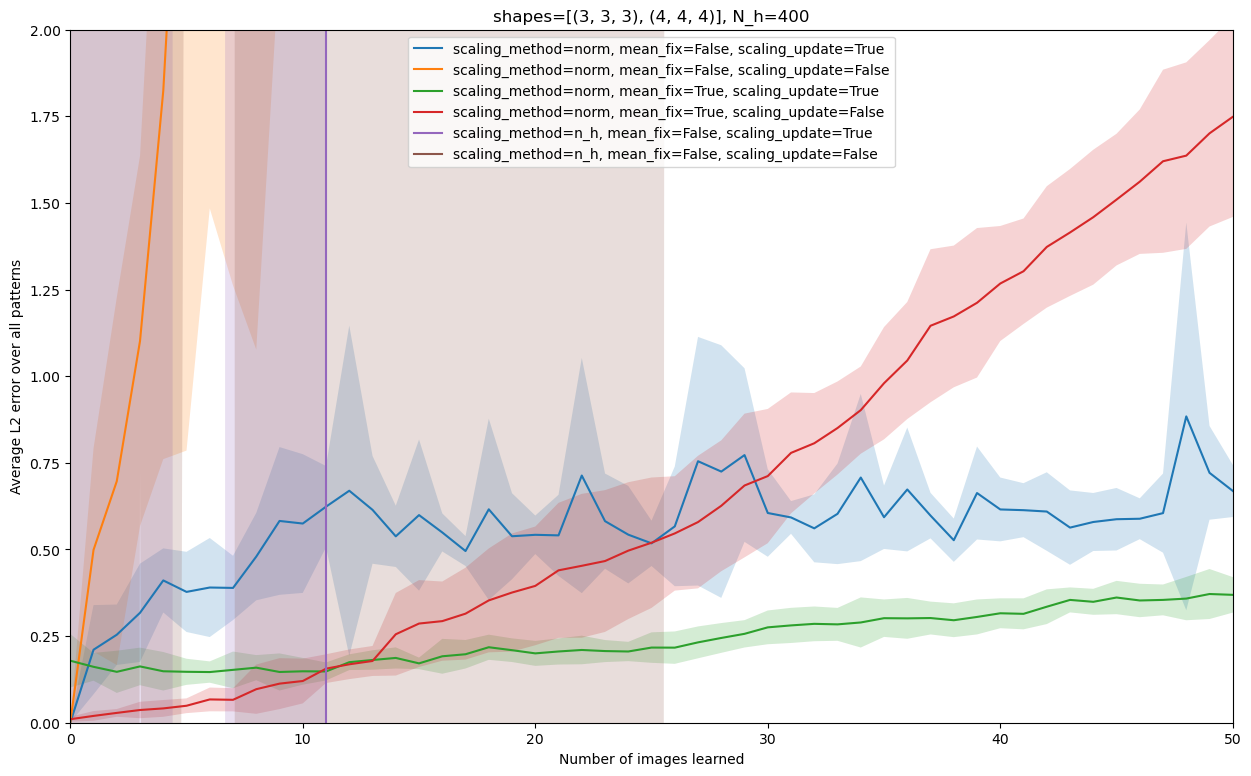

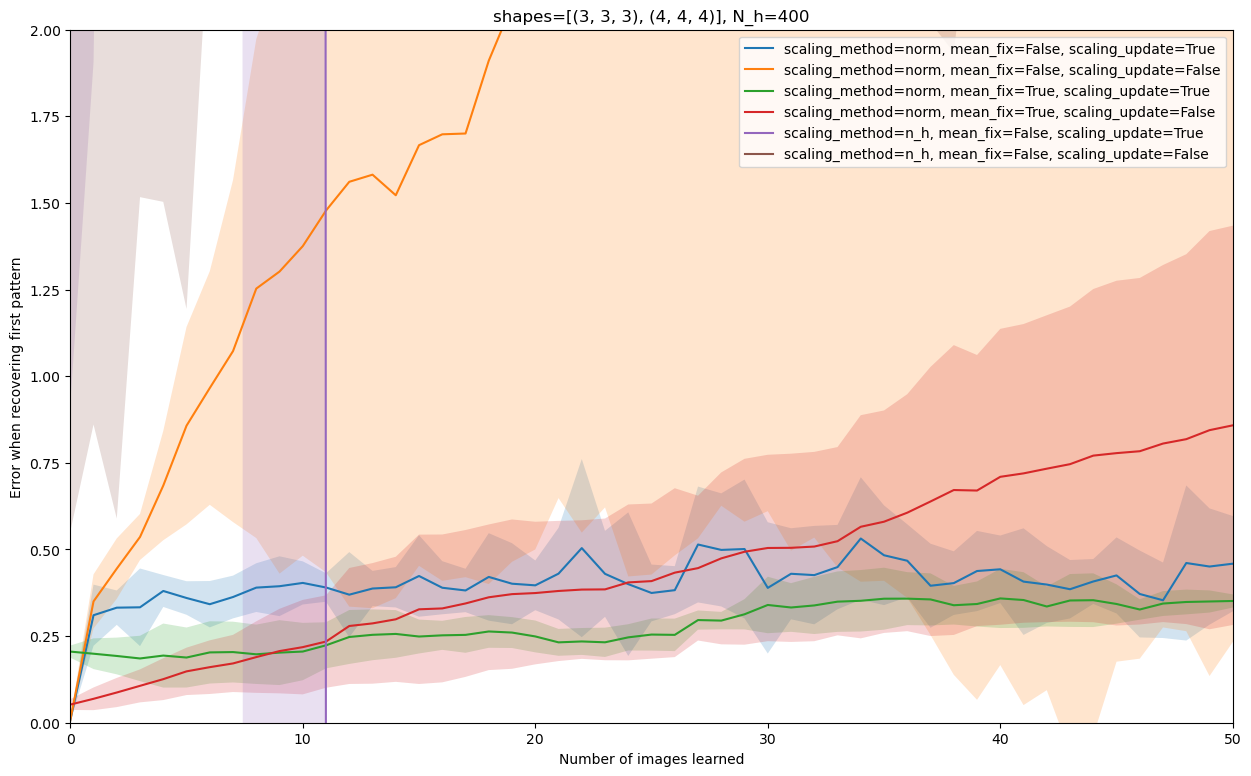

In [7]:
fig, ax = plt.subplots(figsize=(15, 9))

for i, scaling_method in enumerate(scaling_methods):
    for j, mean in enumerate(means):
        for k, scaling_update in enumerate(scaling_updates):
            if mean != None and scaling_method == "n_h":
                continue
            plot_avg_acc_l2_err_on_ax(
                ax,
                avg_accumulated_err_l2[i, j, k],
                label=f"scaling_method={scaling_method}, mean_fix={mean != None}, scaling_update={scaling_update}",
            )
add_vertical_bar_on_ax(ax, N_h)
set_ax_titles(
    ax,
    f"shapes={shapes}, N_h={N_h}",
    "Number of images learned",
    "Average L2 error over all patterns",
)
ax.set_ylim(0, 2)
fig.savefig("hipp_sens_result_hebb_dataset_err_zoom_y")
ax.set_ylim(0, 70**2)
fig.savefig("hipp_sens_result_hebb_dataset_err")
ax.set_ylim(0, 2)
ax.set_xlim(0, 50)
fig.savefig("hipp_sens_result_hebb_dataset_err_zoom_xy")

fig, ax = plt.subplots(figsize=(15, 9))
for i, scaling_method in enumerate(scaling_methods):
    for j, mean in enumerate(means):
        for k, scaling_update in enumerate(scaling_updates):
            if mean != None and scaling_method == "n_h":
                continue
            plot_first_img_l1_err_on_ax(
                ax,
                err_l1_first_img_s_h_s[i, j, k],
                label=f"scaling_method={scaling_method}, mean_fix={mean != None}, scaling_update={scaling_update}",
            )
add_vertical_bar_on_ax(ax, N_h)
set_ax_titles(
    ax,
    f"shapes={shapes}, N_h={N_h}",
    "Number of images learned",
    "Error when recovering first pattern",
)
ax.set_ylim(0, 2)
fig.savefig("hipp_sens_result_hebb_first_img_err_zoom_y")
ax.set_ylim(0, 70)
fig.savefig("hipp_sens_result_hebb_first_img_err")
ax.set_ylim(0, 2)
ax.set_xlim(0, 50)
fig.savefig("hipp_sens_result_hebb_first_img_err_zoom_xy")